In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import tensorflow as tf

In [13]:
from memory_profiler import memory_usage

In [14]:
import time

In [15]:
def Load_WISDM_dataset(file_path):
    cleaned_rows = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            # Line ends with ;, so we may get it as part of the last value
            if len(parts) == 6 or len(parts) == 7:  # Acceptable lines
                try:
                    user = int(parts[0])
                    activity = parts[1]
                    timestamp = int(parts[2])
                    x = float(parts[3])
                    y = float(parts[4])
                    z = float(parts[5].replace(';', ''))  # Clean the ;
                    cleaned_rows.append([user, activity, timestamp, x, y, z])
                except ValueError:
                    continue  # skip malformed lines

    columns = ['user', 'activity', 'timestamp', 'x', 'y', 'z']
    df = pd.DataFrame(cleaned_rows, columns=columns)
    return df

In [16]:
df = Load_WISDM_dataset('datasets/WISDM/WISDM_raw.txt')

In [17]:
df = df.iloc[:500000].copy()
print(df['activity'].value_counts())
print(df.shape)
df.head()

activity
Walking       208519
Jogging       159792
Upstairs       53856
Downstairs     49607
Sitting        15561
Standing       12665
Name: count, dtype: int64
(500000, 6)


,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [7]:
def extract_features_from_window(window):
    features = []

    for axis in ['x', 'y', 'z']:
        data = window[axis]
        features += [
            data.mean(),
            data.std(),
            data.min(),
            data.max(),
            data.median(),
            np.sqrt(np.sum(data**2)),  # Energy
        ]
    return features


In [8]:
def create_feature_dataset(df, window_size=50, step_size=25):
    X_features = []
    y_labels = []

    for user_id in df['user'].unique():
        user_data = df[df['user'] == user_id]

        for i in range(0, len(user_data) - window_size, step_size):
            window = user_data.iloc[i:i+window_size]
            if len(window['activity'].unique()) == 1:
                features = extract_features_from_window(window)
                X_features.append(features)
                y_labels.append(window['activity'].iloc[0])

    return np.array(X_features), np.array(y_labels)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


In [8]:

X_50, y_50 = create_feature_dataset(df, window_size=50, step_size=25)
X_100, y_100 = create_feature_dataset(df, window_size=100, step_size=50)

print(X_50.shape, y_50.shape)
print(X_100.shape, y_100.shape)


NameError: name 'create_feature_dataset' is not defined

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode activity labels to integers
le = LabelEncoder()
y50_encoded = le.fit_transform(y_50)
y100_encoded = le.fit_transform(y_100)

In [ ]:
# Train/Test split with encoded labels
X50_train, X50_test, y50_train, y50_test = train_test_split(X_50, y50_encoded, test_size=0.2, random_state=42)
X100_train, X100_test, y100_train, y100_test = train_test_split(X_100, y100_encoded, test_size=0.2, random_state=42)

In [13]:
# ----------- WINDOW SIZE 50 -----------
scaler_50 = StandardScaler()
X50_train = scaler_50.fit_transform(X50_train)
X50_test = scaler_50.transform(X50_test)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001, 0.0001]
}

def train_model_50():
    grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, verbose=1, n_jobs=-1)
    grid.fit(X50_train, y50_train)
    return grid

start = time.time()
mem_used_svm_50 = memory_usage((train_model_50, ))
end = time.time()
print(f"[Window 50] Training time: {(end - start) * 1000:.2f} ms")
print(f"[Window 50] Max memory used: {max(mem_used_svm_50):.2f} MB")

# Train again to retrieve model
grid_50 = train_model_50()
y50_pred = grid_50.predict(X50_test)
print("Best Parameters (Window 50):", grid_50.best_params_)
print(classification_report(y50_test, y50_pred))


# ----------- WINDOW SIZE 100 -----------
scaler_100 = StandardScaler()
X100_train = scaler_100.fit_transform(X100_train)
X100_test = scaler_100.transform(X100_test)

def train_model_100():
    grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, verbose=1, n_jobs=-1)
    grid.fit(X100_train, y100_train)
    return grid

start = time.time()
mem_used_svm_100 = memory_usage((train_model_100, ))
end = time.time()
print(f"[Window 100] Training time: {(end - start) * 1000:.2f} ms")
print(f"[Window 100] Max memory used: {max(mem_used_svm_100):.2f} MB")

grid_100 = train_model_100()
y100_pred = grid_100.predict(X100_test)
print("Best Parameters (Window 100):", grid_100.best_params_)
print(classification_report(y100_test, y100_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Window 50] Training time: 89656.65 ms
[Window 50] Max memory used: 897.18 MB
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters (Window 50): {'C': 100, 'gamma': 'scale'}
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       407
           1       0.99      0.99      0.99      1279
           2       0.99      1.00      1.00       106
           3       1.00      1.00      1.00        95
           4       0.88      0.83      0.85       428
           5       0.96      0.98      0.97      1612

    accuracy                           0.96      3927
   macro avg       0.95      0.94      0.94      3927
weighted avg       0.96      0.96      0.96      3927

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Window 100] Training time: 10202.81 ms
[Window 100] Max memory used: 890.50 MB
Fitting 5 folds for each of 16 candidates, totalling 80 fi

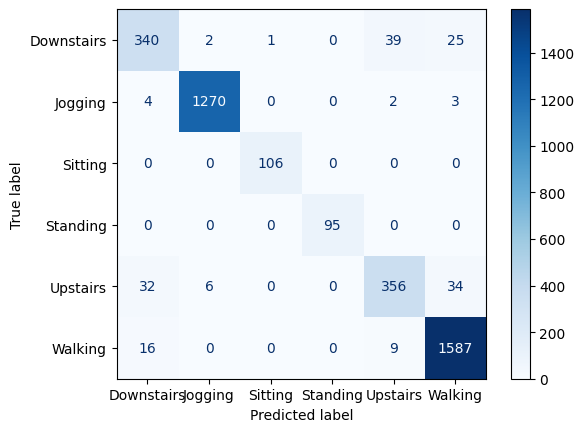

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y50_test, y50_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')

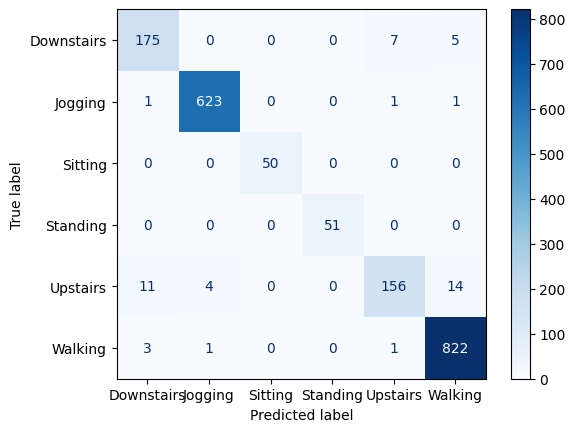

In [15]:
cm = confusion_matrix(y100_test, y100_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')

In [ ]:
# ---------------- Window Size = 50 ----------------
scaler_50 = StandardScaler()
X50_train_scaled = scaler_50.fit_transform(X50_train)
X50_test_scaled = scaler_50.transform(X50_test)

param_grid_poly = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 0.01],
    'coef0': [0, 1]  # affects the polynomial curve
}

grid_poly_50 = GridSearchCV(SVC(kernel='poly'), param_grid_poly, cv=5, verbose=1, n_jobs=-1)
grid_poly_50.fit(X50_train_scaled, y50_train)

y50_pred_poly = grid_poly_50.predict(X50_test_scaled)
print("Best Params (Poly Kernel, Win 50):", grid_poly_50.best_params_)
print(classification_report(y50_test, y50_pred_poly))


# ---------------- Window Size = 100 ----------------
scaler_100 = StandardScaler()
X100_train_scaled = scaler_100.fit_transform(X100_train)
X100_test_scaled = scaler_100.transform(X100_test)

grid_poly_100 = GridSearchCV(SVC(kernel='poly'), param_grid_poly, cv=5, verbose=1, n_jobs=-1)
grid_poly_100.fit(X100_train_scaled, y100_train)

y100_pred_poly = grid_poly_100.predict(X100_test_scaled)
print("Best Params (Poly Kernel, Win 100):", grid_poly_100.best_params_)
print(classification_report(y100_test, y100_pred_poly))


Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [18]:
# 1D CNN

In [19]:

def create_sequence_dataset(df, window_size=50, step_size=25):
    X, y = [], []
    for i in range(0, len(df) - window_size, step_size):
        window = df.iloc[i:i+window_size]
        if len(window['activity'].unique()) == 1:  # Consistent label in window
            X.append(window[['x', 'y', 'z']].values)
            y.append(window['activity'].iloc[0])
    return np.array(X), np.array(y)


In [20]:
X_seq_50, y_seq_50 = create_sequence_dataset(df, window_size=50, step_size=25)
X_seq_100, y_seq_100 = create_sequence_dataset(df, window_size=100, step_size=50)


In [21]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y50_encoded = to_categorical(label_encoder.fit_transform(y_seq_50))
y100_encoded = to_categorical(label_encoder.transform(y_seq_100))  # same encoder


In [22]:
from sklearn.model_selection import train_test_split

X50_train, X50_test, y50_train, y50_test = train_test_split(X_seq_50, y50_encoded, test_size=0.2, random_state=42)
X100_train, X100_test, y100_train, y100_test = train_test_split(X_seq_100, y100_encoded, test_size=0.2, random_state=42)


In [19]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# CNN model factory function
def create_cnn_model(input_shape, num_classes, filters=32, dropout_rate=0.5):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [24]:
def train_best_cnn(X_train, y_train, X_test, y_test, window_size):
    best_score = 0
    best_model = None
    best_params = {}

    input_shape = (window_size, 3)
    num_classes = y_train.shape[1]

    param_grid = {
        'filters': [32, 64],
        'dropout_rate': [0.3, 0.5],
        'batch_size': [16, 32],
    }

    for filters in param_grid['filters']:
        for dropout in param_grid['dropout_rate']:
            for batch_size in param_grid['batch_size']:
                model = create_cnn_model(input_shape, num_classes, filters=filters, dropout_rate=dropout)

                history = model.fit(
                    X_train, y_train,
                    epochs=10,
                    batch_size=batch_size,
                    validation_split=0.2,
                    verbose=0
                )

                val_acc = max(history.history['val_accuracy'])
                print(f"[Window {window_size}] Filters: {filters}, Dropout: {dropout}, Batch Size: {batch_size}, Val Acc: {val_acc:.4f}")

                if val_acc > best_score:
                    best_score = val_acc
                    best_model = model
                    best_params = {
                        'filters': filters,
                        'dropout_rate': dropout,
                        'batch_size': batch_size
                    }

    test_loss, test_acc = best_model.evaluate(X_test, y_test)
    print(f"[Window {window_size}] Best Params: {best_params}")
    print(f"[Window {window_size}] Test Accuracy: {test_acc:.4f}")
    return best_model, best_params


In [25]:
start_50 = time.time()
best_model_50, best_params_50 = train_best_cnn(X50_train, y50_train, X50_test, y50_test, window_size=50)
end_50 = time.time()
print(f"[Window 50] Training Time: {(end_50 - start_50):.2f} sec")

start_100 = time.time()
best_model_100, best_params_100 = train_best_cnn(X100_train, y100_train, X100_test, y100_test, window_size=100)
end_100 = time.time()
print(f"[Window 100] Training Time: {(end_100 - start_100):.2f} sec")


[Window 50] Filters: 32, Dropout: 0.3, Batch Size: 16, Val Acc: 0.9297
[Window 50] Filters: 32, Dropout: 0.3, Batch Size: 32, Val Acc: 0.9354
[Window 50] Filters: 32, Dropout: 0.5, Batch Size: 16, Val Acc: 0.9128
[Window 50] Filters: 32, Dropout: 0.5, Batch Size: 32, Val Acc: 0.9239
[Window 50] Filters: 64, Dropout: 0.3, Batch Size: 16, Val Acc: 0.9411
[Window 50] Filters: 64, Dropout: 0.3, Batch Size: 32, Val Acc: 0.9290
[Window 50] Filters: 64, Dropout: 0.5, Batch Size: 16, Val Acc: 0.9290
[Window 50] Filters: 64, Dropout: 0.5, Batch Size: 32, Val Acc: 0.9278
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9392 - loss: 0.2280
[Window 50] Best Params: {'filters': 64, 'dropout_rate': 0.3, 'batch_size': 16}
[Window 50] Test Accuracy: 0.9412
[Window 50] Training Time: 415.76 sec
[Window 100] Filters: 32, Dropout: 0.3, Batch Size: 16, Val Acc: 0.9208
[Window 100] Filters: 32, Dropout: 0.3, Batch Size: 32, Val Acc: 0.9325
[Window 100] Filters: 32, Dropout: 0.5, Batch Size: 16, Val A

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_test, y_test, label_encoder, title="Confusion Matrix"):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    labels = label_encoder.classes_

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=labels))


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


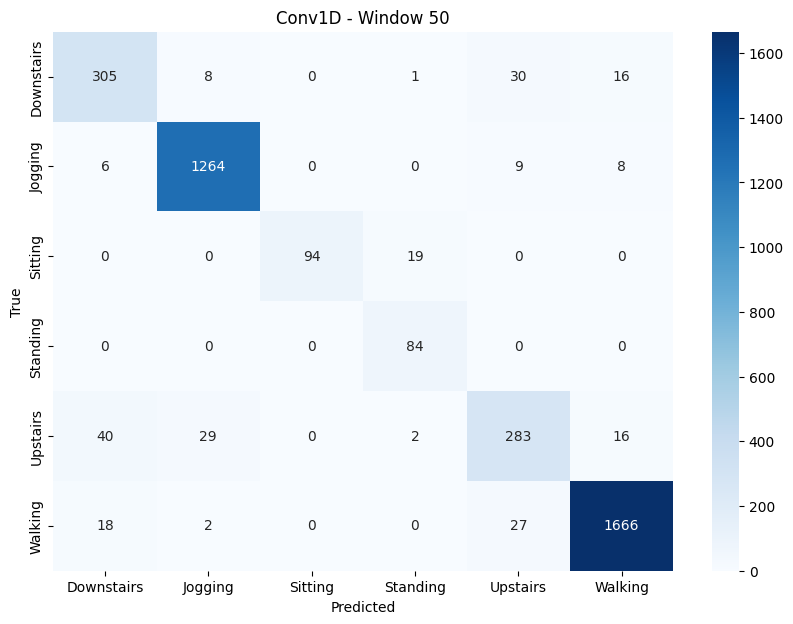

Classification Report:

              precision    recall  f1-score   support

  Downstairs       0.83      0.85      0.84       360
     Jogging       0.97      0.98      0.98      1287
     Sitting       1.00      0.83      0.91       113
    Standing       0.79      1.00      0.88        84
    Upstairs       0.81      0.76      0.79       370
     Walking       0.98      0.97      0.97      1713

    accuracy                           0.94      3927
   macro avg       0.90      0.90      0.89      3927
weighted avg       0.94      0.94      0.94      3927

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


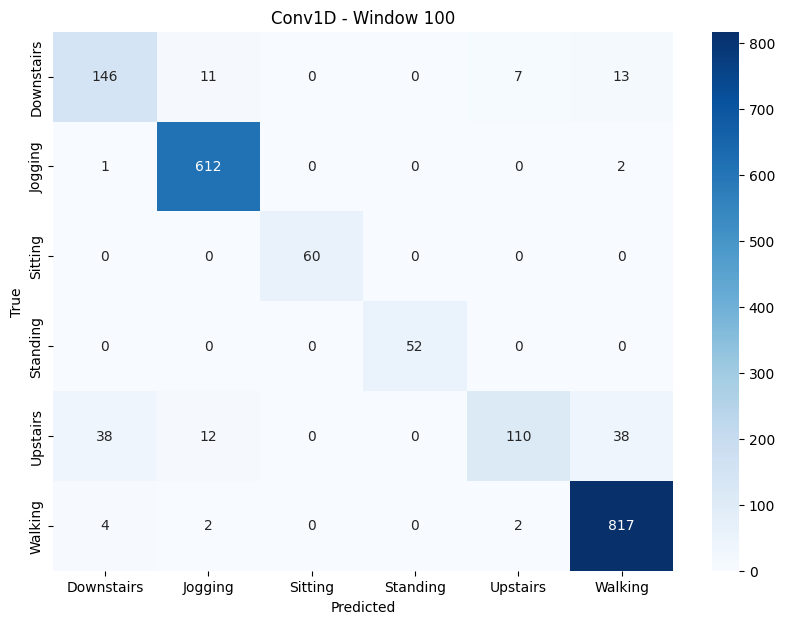

Classification Report:

              precision    recall  f1-score   support

  Downstairs       0.77      0.82      0.80       177
     Jogging       0.96      1.00      0.98       615
     Sitting       1.00      1.00      1.00        60
    Standing       1.00      1.00      1.00        52
    Upstairs       0.92      0.56      0.69       198
     Walking       0.94      0.99      0.96       825

    accuracy                           0.93      1927
   macro avg       0.93      0.89      0.91      1927
weighted avg       0.93      0.93      0.93      1927



In [27]:
plot_confusion_matrix(best_model_50, X50_test, y50_test, label_encoder, title="Conv1D - Window 50")
plot_confusion_matrix(best_model_100, X100_test, y100_test, label_encoder, title="Conv1D - Window 100")


In [ ]:
# LSTM

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
import time
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [24]:
# Print original shapes to understand dimensions
print(f"X50_train shape: {X50_train.shape}, y50_train shape: {y50_train.shape}")
print(f"X50_test shape: {X50_test.shape}, y50_test shape: {y50_test.shape}")
print(f"X100_train shape: {X100_train.shape}, y100_train shape: {y100_train.shape}")
print(f"X100_test shape: {X100_test.shape}, y100_test shape: {y100_test.shape}")

X50_train shape: (15706, 50, 3), y50_train shape: (15706, 6)
X50_test shape: (3927, 50, 3), y50_test shape: (3927, 6)
X100_train shape: (7704, 100, 3), y100_train shape: (7704, 6)
X100_test shape: (1927, 100, 3), y100_test shape: (1927, 6)


In [25]:
def build_lstm_model(input_shape, units=64, dropout_rate=0.3):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(6, activation='softmax'))  # 6 classes
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [30]:
params_list = [
    #{'units': 64, 'dropout': 0.3, 'batch_size': 16},
    #{'units': 64, 'dropout': 0.3, 'batch_size': 32},
    {'units': 64, 'dropout': 0.5, 'batch_size': 16},
    #{'units': 64, 'dropout': 0.5, 'batch_size': 32},
]

In [31]:
# ---------- For window size 50 ----------
best_val_acc_50 = 0
best_model_50 = None
print("\n===== LSTM Training: Window Size 50 =====")
for params in params_list:
    print(f"\n[Window 50] Params: {params}")
    model = build_lstm_model(input_shape=(50, 3), units=params['units'], dropout_rate=params['dropout'])
    
    start = time.time()
    history = model.fit(X50_train, y50_train, epochs=10, batch_size=params['batch_size'],
                        validation_split=0.2, verbose=0)
    duration = time.time() - start

    val_acc = max(history.history['val_accuracy'])
    print(f"[Window 50] Val Acc: {val_acc:.4f} | Time: {duration:.2f} sec")

    if val_acc > best_val_acc_50:
        best_val_acc_50 = val_acc
        best_model_50 = model
        best_params_50 = params

# Evaluate on test set
test_loss_50, test_acc_50 = best_model_50.evaluate(X50_test, y50_test, verbose=0)
print(f"\n[Window 50] Best Params: {best_params_50}")
print(f"[Window 50] Test Accuracy: {test_acc_50:.4f}")
best_model_50.save("app/model/LSTM_model_50.h5")


===== LSTM Training: Window Size 50 =====

[Window 50] Params: {'units': 64, 'dropout': 0.5, 'batch_size': 16}
[Window 50] Val Acc: 0.9694 | Time: 128.02 sec



[Window 50] Best Params: {'units': 64, 'dropout': 0.5, 'batch_size': 16}
[Window 50] Test Accuracy: 0.9728


In [23]:
# ---------- For window size 100 ----------
best_val_acc_100 = 0
best_model_100 = None
print("\n===== LSTM Training: Window Size 100 =====")
for params in params_list:
    print(f"\n[Window 100] Params: {params}")
    model = build_lstm_model(input_shape=(100, 3), units=params['units'], dropout_rate=params['dropout'])
    
    start = time.time()
    history = model.fit(X100_train, y100_train, epochs=10, batch_size=params['batch_size'],
                        validation_split=0.2, verbose=0)
    duration = time.time() - start

    val_acc = max(history.history['val_accuracy'])
    print(f"[Window 100] Val Acc: {val_acc:.4f} | Time: {duration:.2f} sec")

    if val_acc > best_val_acc_100:
        best_val_acc_100 = val_acc
        best_model_100 = model
        best_params_100 = params

# Evaluate on test set
test_loss_100, test_acc_100 = best_model_100.evaluate(X100_test, y100_test, verbose=0)
print(f"\n[Window 100] Best Params: {best_params_100}")
print(f"[Window 100] Test Accuracy: {test_acc_100:.4f}")


===== LSTM Training: Window Size 100 =====

[Window 100] Params: {'units': 64, 'dropout': 0.3, 'batch_size': 16}
[Window 100] Val Acc: 0.9663 | Time: 208.10 sec

[Window 100] Params: {'units': 64, 'dropout': 0.3, 'batch_size': 32}
[Window 100] Val Acc: 0.9539 | Time: 112.51 sec

[Window 100] Params: {'units': 64, 'dropout': 0.5, 'batch_size': 16}
[Window 100] Val Acc: 0.9565 | Time: 204.80 sec

[Window 100] Params: {'units': 64, 'dropout': 0.5, 'batch_size': 32}
[Window 100] Val Acc: 0.9461 | Time: 129.18 sec

[Window 100] Best Params: {'units': 64, 'dropout': 0.3, 'batch_size': 16}
[Window 100] Test Accuracy: 0.9704


In [33]:


# LSTM Predictions
y_pred_lstm50 = best_model_50.predict(X50_test)
y_pred_lstm100 = best_model_100.predict(X100_test)

# Decode predictions
y_true_50 = np.argmax(y50_test, axis=1)
y_true_100 = np.argmax(y100_test, axis=1)

y_pred_lstm50 = np.argmax(y_pred_lstm50, axis=1)
y_pred_lstm100 = np.argmax(y_pred_lstm100, axis=1)

def get_weighted_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return {
        'Accuracy': report['accuracy'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    }

# Collect metrics
results = {
    'LSTM (50)': get_weighted_metrics(y_true_50, y_pred_lstm50),
    'LSTM (100)': get_weighted_metrics(y_true_100, y_pred_lstm100),
}

# Convert to DataFrame
df_results = pd.DataFrame(results).T
df_results = df_results.round(4)
print(df_results)



123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
            Accuracy  Precision  Recall  F1-Score
LSTM (50)     0.9743     0.9743  0.9743    0.9743
LSTM (100)    0.9704     0.9700  0.9704    0.9701


123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


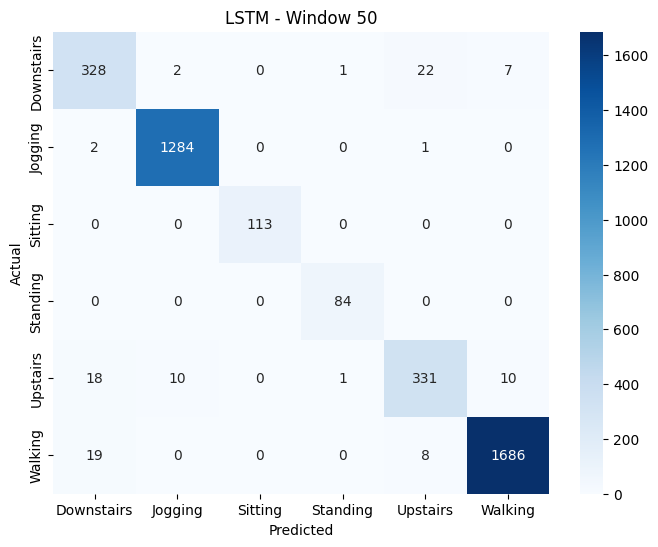

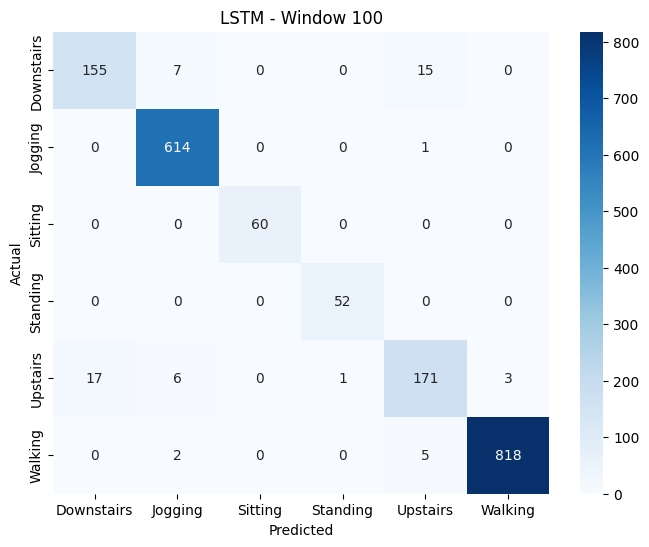

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# True labels
y_true_50 = np.argmax(y50_test, axis=1)
y_true_100 = np.argmax(y100_test, axis=1)

# LSTM Predictions
y_pred_lstm50 = np.argmax(best_model_50.predict(X50_test), axis=1)
y_pred_lstm100 = np.argmax(best_model_100.predict(X100_test), axis=1)

# Get activity label names
labels = label_encoder.classes_

plot_conf_matrix(y_true_50, y_pred_lstm50, labels, "LSTM - Window 50")
plot_conf_matrix(y_true_100, y_pred_lstm100, labels, "LSTM - Window 100")
